In [10]:

# Imports and basic functions

import matplotlib.pyplot as plt
import matplotlib.image as io
import cv2
import numpy as np


def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated
    # titles. images[0] will be drawn with the title titles[0] if exists You aren't required to understand this
    # function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
        
def show_hist(hist):
    plt.plot(hist)
    plt.show()


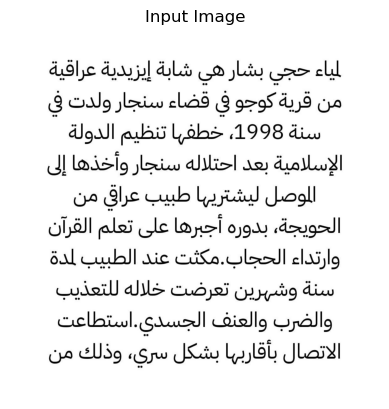

In [11]:
img_path = "train-dataset/IBM Plex Sans Arabic/1.jpeg"
input_image = cv2.imread(img_path)
show_images([input_image] , ["Input Image"])

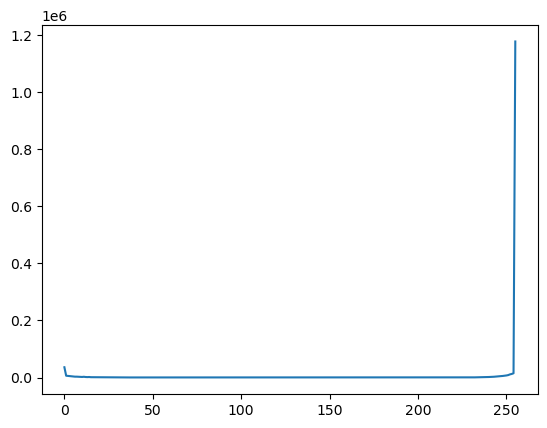

Image Shape:  (1181, 1181)


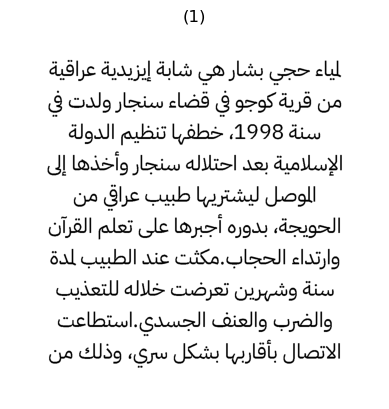

True

In [12]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    histogram = cv2.calcHist([gray], [0], None, [256], [0, 256])
    show_hist(histogram)
    max_index = np.argmax(histogram)
    size = gray.shape
    if ((histogram[max_index] - size[0] * size[1]) / (size[0] * size[1])) > 0.95:
        # image is empty
        return gray , True
    thres = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]
    if max_index < 100:
        thres = 1 - thres
    return thres, False
    
seg , empty = preprocess_image(input_image)
if empty:
    print("Empty Image")

print("Image Shape: ", seg.shape)
show_images([seg])

cv2.imwrite("temp/seg.png" , seg)

Found: 10 Lines


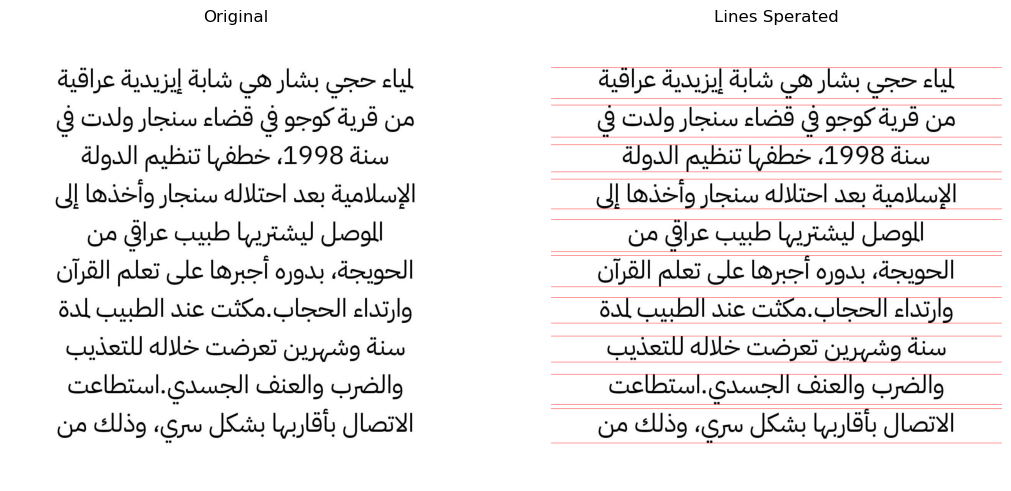

In [13]:

# in this stage we try to calculate where each line is at
# idea:
#   - create a horizental projection of the image
#   - check for peaks
#   - merge close peaks with certain threshold
#   - draw lines for testing ..
def separate_lines(image , MinOfMean = 0.8, temp=None, showHist=False):
    # find the horizental projection
    projection = np.sum(image, axis=1)
    shape = image.shape
    
    if showHist:
        show_hist(projection)

    flag = 0
    start = -1
    lines = []
    line_widths = []
    for i in range(len(projection)):
        if projection[i] != (shape[1]) and flag == 0: # start
            start = i - 1
            flag = 1
        if projection[i] == (shape[1]) and flag == 1: #end
            lines.append([start, i])
            line_widths.append(i - start)
            flag = 0

    mean_value = np.mean(line_widths)
    min_value = mean_value * MinOfMean

    i = 0
    while i < len(lines):
        if line_widths[i] < min_value:
            
            if i != 0:
                # try to merge it with the line before it ..
                l = lines.pop(i)
                w = line_widths.pop(i)
                lines[i - 1][1] = l[1]
                line_widths[i - 1] = lines[i - 1][1] - lines[i - 1][0]
                i = i - 1
            elif i != len(lines) - 1:
                # try to merge it with the line after it ..
                l = lines.pop(i)
                w = line_widths.pop(i)
                lines[i][1] = l[1]
                line_widths[i] = lines[i][1] - lines[i][0]
                i = i - 1
            else:
                # can't merge it ..
                l = lines.pop(i)
                w = line_widths.pop(i)
                i = i - 1
            
        i = i + 1

    print("Found: %d Lines" % len(lines))

    if temp is not None:
        for i in range(len(lines)):
            cv2.line(temp , (0 , lines[i][0]) , (shape[1],lines[i][0]) , (255,0,0), 1)
            cv2.line(temp , (0 , lines[i][1]) , (shape[1],lines[i][1]) , (255,0,0), 1)
    return lines


lines_image = np.copy(input_image)
lines = separate_lines(seg // 255 , temp=lines_image)
show_images([input_image , lines_image] , ["Original" , "Lines Sperated"])

Found: 8 Gaps
Found: 7 Words
Found: 8 Gaps
Found: 7 Words
Found: 6 Gaps
Found: 5 Words
Found: 7 Gaps
Found: 6 Words
Found: 6 Gaps
Found: 5 Words
Found: 7 Gaps
Found: 6 Words
Found: 6 Gaps
Found: 5 Words
Found: 6 Gaps
Found: 5 Words
Found: 4 Gaps
Found: 3 Words
Found: 7 Gaps
Found: 6 Words


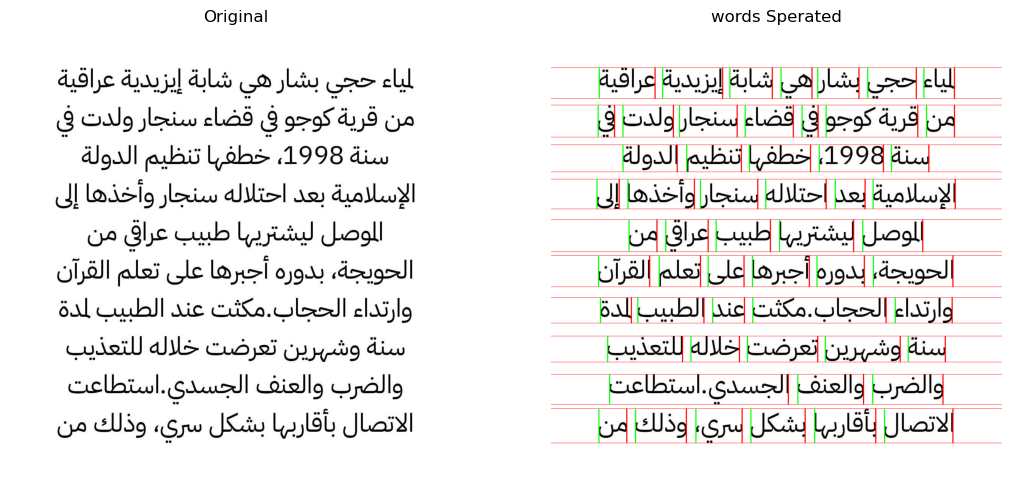

In [14]:
# now we need to separate words itself from each other
# to do this we will take similar approch but on the vertical axis

def separate_words(image, line , MinOfMean = 0.8, temp=None, showHist=False):
    # find the horizental projection
    projection = np.sum(image[line[0]:line[1] , :], axis=0)
    shape = image.shape
    if showHist:
        show_hist(projection)

    flag = 0
    start = 0
    lines = []
    line_widths = []
    for i in range(len(projection)):
        if projection[i] == (line[1] - line[0]) and flag == 0: # start
            start = i - 1
            flag = 1
        if (projection[i] != (line[1] - line[0]) and flag == 1) or (i == len(projection) - 1): #end
            lines.append([start, i])
            line_widths.append(i - start)
            flag = 0

    mean_value = np.mean(line_widths[1:-1])
    min_value = mean_value * MinOfMean

    # remove small gaps (aka: gaps inside the same word)
    i = 0
    while i < len(lines):
        if line_widths[i] < min_value:
            l = lines.pop(i)
            w = line_widths.pop(i)
            i = i - 1
        i = i + 1
    print("Found: %d Gaps" % len(lines))

    # now that we have the gaps, we can calculate words positions
    words = []
    for i in range(len(lines)):
        if i != len(lines) - 1:
            words.append([lines[i][1] , lines[i + 1][0]])

    print("Found: %d Words" % len(words))

    if temp is not None:
        for i in range(len(words)):
            cv2.line(temp , (words[i][0] , line[0]) , (words[i][0] ,line[1]) , (0,255,0), 2)
            cv2.line(temp , (words[i][1] , line[0]) , (words[i][1] ,line[1]) , (255,0,0), 2)

    return words , lines



words_image = np.copy(lines_image)
words = []
for line in lines:
    words.append(separate_words(seg // 255 , line , 1 , words_image)[0])
    
show_images([input_image , words_image] , ["Original" , "words Sperated"])


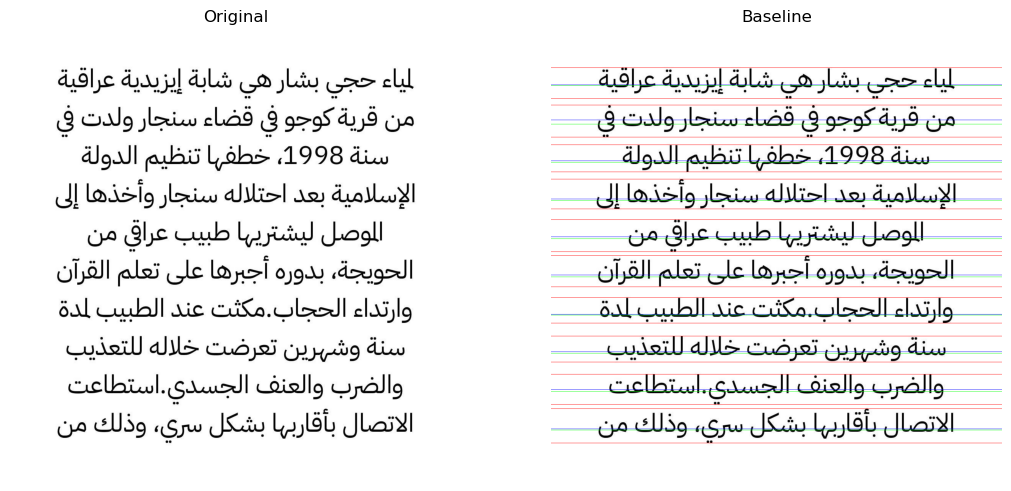

In [15]:
# now that we have the words in each line, what we need to do next is to
# calculate the baseline of the each line as well as the line that achieves
# the most intersections above the base line, sinece it will help use find
# each character region
def find_baseline(image, line, temp=None , showHist=True):
    projection = np.sum(image[line[0]:line[1] , :], axis=1)
    shape = image.shape
    if showHist:
        show_hist(projection)

    kernel = np.ones(3) / 3
    smoothed = np.convolve(projection , kernel, mode='same')
    if showHist:
        show_hist(smoothed)

    baseline = np.argmin(smoothed)

    i = baseline - 1
    maxTransitionsIndex = -1
    maxTransitions = 0

    while i >= 0:
        # calculate the transitions
        t = 0
        f = 0
        for k in range(shape[1]):
            if image[i + line[0] , k] == 0 and f == 0:
                f = 1
            if image[i + line[0] , k] != 0 and f == 1:
                f = 0
                t += 1
        if t > maxTransitions:
            maxTransitions = t
            maxTransitionsIndex = i
        i = i - 1
    # now we need to calculate the 
    if temp is not None:
        cv2.line(temp , (0 , baseline + line[0]) , (shape[1], baseline + line[0]) , (0,255,0), 1)
        cv2.line(temp , (0 , maxTransitionsIndex + line[0]) , (shape[1], maxTransitionsIndex + line[0]) , (0,0,255), 1)

    return baseline , maxTransitionsIndex
            

baseline_image = np.copy(lines_image)
baselines = []
for line in lines:
    baselines.append(find_baseline(seg // 255 , line , temp=baseline_image, showHist=False))

show_images([input_image , baseline_image] , ["Original" , "Baseline"])

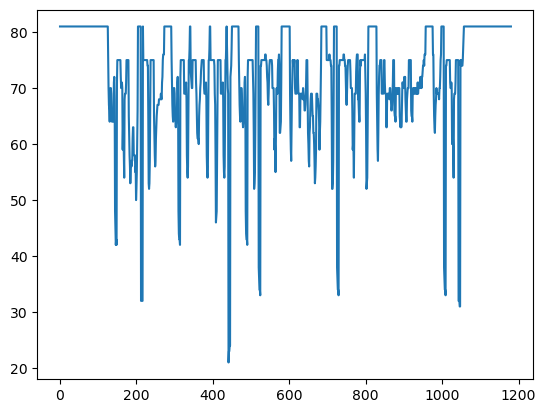

Baseline width: 75


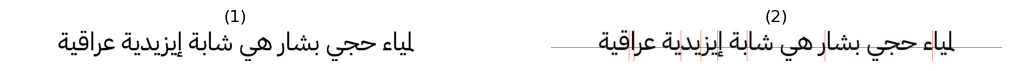

[[(202, 212, 204), (217, 232, 217)],
 [(336, 342, 340), (388, 408, 392), (432, 441, 436)],
 [(512, 520, 513)],
 [],
 [(717, 725, 717)],
 [],
 [(985, 1005, 998)]]

In [16]:
# now to generate the separation regions ..
from collections import Counter

def find_cut_points(image , line , words , maxTransitionsLine , temp=None , show=True):
    line_img = image[line[0]:line[1] , :]
    kernal = kernel = np.ones((2, 2), np.uint8)
    opened_img = cv2.morphologyEx(line_img, cv2.MORPH_OPEN, kernel)
    
    VP = np.sum(line_img, axis=0)
    if show:
        show_hist(VP)

    vertical_projection = np.sum(line_img[:, words[0][0]:words[-1][1]], axis=0)
    mods                = Counter(vertical_projection)
    baselines_width     = mods.most_common(1)[0][0]
    line_height = line[1] - line[0]
    print(f"Baseline width: {baselines_width}")

    totalSRs = []
    for word in words:
        i = 0
        f = 0
        end_index = -1
        SRs = []
        for i in range(word[0] , word[1]):
            sr = None
            if line_img[maxTransitionsLine , i] != 0 and f == 0: # unlike paper, words are letters are colored black!! 
                f = 1
                end_index = i
            if line_img[maxTransitionsLine , i] == 0 and f == 1:
                start_index = i
                mid = (start_index + end_index) // 2
                f = 0
                if (start_index - end_index) / (word[1] - word[0]) < 0.01:
                    continue
                
                for k in range(end_index, start_index - 1):
                    if (VP[k] == line_height):
                        sr = (end_index , start_index , k)
                        break
                if sr != None:
                    SRs.append(sr)
                    continue

                if VP[mid] == baselines_width:
                    sr = (end_index , start_index , mid)
                    SRs.append(sr)
                    continue

                for k in range(end_index, start_index - 1):
                    if (VP[k] >= baselines_width):
                        sr = (end_index , start_index , k)
                        break
                
                if sr != None:
                    SRs.append(sr)
                    continue

                sr = (end_index , start_index , mid)
                SRs.append(sr)

        totalSRs.append(SRs)


    SRs_image = np.copy(input_image[line[0]:line[1], :])

    totalValidSRs = []
    for k in totalSRs:
        validSRs = []
        for j in k:
            end   = j[0]
            start = j[1]
            div   = j[2] # div is the cut point
            if VP[div] == line_height: # case 1 : speration is not inside a character
                validSRs.append(j)
            elif np.min(np.sum(line_img[:,end:start] , axis=1)) != 0: # case 2 : no connected path between start and end
                validSRs.append(j)
            
        totalValidSRs.append(validSRs)
            

    for k in totalValidSRs: # debug draw ..
        for j in k:
            cv2.line(SRs_image , (j[2] , 0) , (j[2] , line_height) , (255 , 0 , 0) , 1)

    if show:
        cv2.line(SRs_image , (0 , maxTransitionsLine) , (SRs_image.shape[1], maxTransitionsLine) , (0,0,255), 1)
        show_images([opened_img , SRs_image])

    return totalValidSRs
    

                

find_cut_points(seg // 255 , lines[0] , words[0] , baselines[0][1])